<a href="https://colab.research.google.com/github/cdixson-ds/DS-Unit-2-Applied-Modeling/blob/master/LS_DS_234_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

df_basic = pd.read_csv('https://datasets.imdbws.com/title.basics.tsv.gz', sep='\t', na_values=[r'\N','\\N'], low_memory=False)
df_rating = pd.read_csv('https://datasets.imdbws.com/title.ratings.tsv.gz', sep='\t', na_values=[r'\N','\\N'], low_memory=False)

In [70]:
#Look at the shape of both dataframes

df_basic.shape, df_rating.shape

((6508423, 9), (1020202, 3))

In [0]:
#Merged here because I would have to strip 'tconst' in both datasets to 
#perform a merger

df_imdb = pd.merge(df_basic, df_rating, on='tconst')

In [72]:
df_imdb.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,NaN,1,"Documentary,Short",5.6,1578
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,NaN,5,"Animation,Short",6.1,189
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,NaN,4,"Animation,Comedy,Romance",6.5,1242
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,NaN,NaN,"Animation,Short",6.2,117
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,NaN,1,"Comedy,Short",6.1,1986


In [73]:
df_imdb.shape

(1020202, 11)

In [0]:
#drop tv/game tags that aren't needed since I am focusing on movies

df_imdb = df_imdb[~df_imdb['titleType'].isin(['short', 'tvShort', 'videoGame', 'tvSpecial', 'tvMiniSeries', 'tvMovie', 'tvSeries', 'video', 'short', 'tvEpisode'])]

In [0]:
df_imdb = df_imdb.drop(columns=['originalTitle', 'isAdult', 'originalTitle','runtimeMinutes', 'endYear', 'titleType'])

In [76]:
df_imdb.head()

,tconst,primaryTitle,startYear,genres,averageRating,numVotes
8,tt0000009,Miss Jerry,1894.0,Romance,5.4,86
144,tt0000147,The Corbett-Fitzsimmons Fight,1897.0,"Documentary,News,Sport",5.2,324
249,tt0000335,Soldiers of the Cross,1900.0,"Biography,Drama",6.1,40
325,tt0000502,Bohemios,1905.0,NaN,4.4,5
359,tt0000574,The Story of the Kelly Gang,1906.0,"Biography,Crime,Drama",6.1,552


In [0]:
#strip tt off tconst

df_imdb['tconst'] = df_imdb['tconst'].str.strip('tt')

In [0]:
#convert tconst to an integer

df_imdb['tconst'] = df_imdb['tconst'].astype(int)

In [79]:
df_imdb.head()

,tconst,primaryTitle,startYear,genres,averageRating,numVotes
8,9,Miss Jerry,1894.0,Romance,5.4,86
144,147,The Corbett-Fitzsimmons Fight,1897.0,"Documentary,News,Sport",5.2,324
249,335,Soldiers of the Cross,1900.0,"Biography,Drama",6.1,40
325,502,Bohemios,1905.0,NaN,4.4,5
359,574,The Story of the Kelly Gang,1906.0,"Biography,Crime,Drama",6.1,552


In [0]:
df_imdb = df_imdb.dropna()
df_imdb['startYear'] = df_imdb['startYear'].astype(int)

In [81]:
df_imdb.head()

,tconst,primaryTitle,startYear,genres,averageRating,numVotes
8,9,Miss Jerry,1894,Romance,5.4,86
144,147,The Corbett-Fitzsimmons Fight,1897,"Documentary,News,Sport",5.2,324
249,335,Soldiers of the Cross,1900,"Biography,Drama",6.1,40
359,574,The Story of the Kelly Gang,1906,"Biography,Crime,Drama",6.1,552
377,615,Robbery Under Arms,1907,Drama,4.8,14


In [0]:
df_imdb['genres'] = df_imdb['genres'].str.lower()

In [0]:
drama = df_imdb['genres'].str.contains('drama')
comedy = df_imdb['genres'].str.contains('comedy')
documentary = df_imdb['genres'].str.contains('documentary')
romance = df_imdb['genres'].str.contains('romance')
family = df_imdb['genres'].str.contains('family')
animation = df_imdb['genres'].str.contains('animation')
crime = df_imdb['genres'].str.contains('crime')
action = df_imdb['genres'].str.contains('action')
adventure = df_imdb['genres'].str.contains('adventure')
mystery = df_imdb['genres'].str.contains('mystery')
musical = df_imdb['genres'].str.contains('musical')
thriller = df_imdb['genres'].str.contains('thriller')
horror = df_imdb['genres'].str.contains('horror')
sci_fi = df_imdb['genres'].str.contains('sci')
fantasy = df_imdb['genres'].str.contains('fantasy')
war = df_imdb['genres'].str.contains('war')
western = df_imdb['genres'].str.contains('western')
film_noir = df_imdb['genres'].str.contains('film')
mystery = df_imdb['genres'].str.contains('mystery')
history = df_imdb['genres'].str.contains('history')
sport = df_imdb['genres'].str.contains('sport')
biography = df_imdb['genres'].str.contains('biography')

In [0]:
df_imdb.loc[drama, 'genres'] = 'drama'
df_imdb.loc[comedy, 'genres'] = 'comedy'
df_imdb.loc[documentary, 'genres'] = 'documentary'
df_imdb.loc[romance, 'genres'] = 'romance'
df_imdb.loc[family, 'genres'] = 'family'
df_imdb.loc[animation, 'genres'] = 'animation'
df_imdb.loc[crime, 'genres'] = 'crime'
df_imdb.loc[action, 'genres'] = 'action'
df_imdb.loc[adventure, 'genres'] = 'adventure'
df_imdb.loc[mystery, 'genres'] = 'mystery'
df_imdb.loc[thriller, 'genres'] = 'thriller'
df_imdb.loc[horror, 'genres'] = 'horror'
df_imdb.loc[sci_fi, 'genres']  ='sci_fi'
df_imdb.loc[fantasy, 'genres']  ='fantasy'
df_imdb.loc[war, 'genres']  ='war'
df_imdb.loc[western, 'genres']  ='western'
df_imdb.loc[film_noir, 'genres'] ='film_noir'
df_imdb.loc[mystery, 'genres'] ='mystery'
df_imdb.loc[history, 'genres'] ='history'
df_imdb.loc[sport, 'genres'] ='sport'
df_imdb.loc[biography, 'genres'] ='biography'

In [0]:
df_imdb = df_imdb[~df_imdb['genres'].isin(['music,reality-tv''reality-tv,talk-show', 
                                              'news,talk-show',
                                              'news,talk-show',
                                              'adult,music',
                                              'music,talk-show',
                                              'news,reality-tv,talk-show',
                                              'game-show,music',
                                              'adult,short',
                                              'music,musical',
                                              'adult,musical',
                                              'music,musical,reality-tv',
                                              'musical,reality-tv',
                                              'short',
                                              'reality-tv,talk-show',
                                              'news',
                                              'talk-show',
                                              'reality-tv',
                                              'game-show',
                                              '\\n',
                                              'music,reality-tv',
                                              'music'
                                              ])]

In [86]:
#pd.set_option('display.max_rows', None)

df_imdb['genres'].value_counts()

drama          42965
comedy         33030
documentary    25623
romance        19819
action         13099
thriller       12328
horror         12298
adventure      11559
mystery         8749
crime           8239
biography       7244
fantasy         6555
family          5415
history         5141
sci_fi          5049
war             4550
western         3841
sport           2554
adult           2386
animation       1581
musical          744
film_noir        684
Name: genres, dtype: int64

In [87]:
df_imdb.shape

(233453, 6)

In [0]:
#df_imdb = df_imdb.reset_index(drop=True)

In [88]:
df_imdb.head()

,tconst,primaryTitle,startYear,genres,averageRating,numVotes
8,9,Miss Jerry,1894,romance,5.4,86
144,147,The Corbett-Fitzsimmons Fight,1897,sport,5.2,324
249,335,Soldiers of the Cross,1900,biography,6.1,40
359,574,The Story of the Kelly Gang,1906,biography,6.1,552
377,615,Robbery Under Arms,1907,drama,4.8,14


In [0]:
target = df_imdb['averageRating']
features = df_imdb.columns.drop('averageRating')

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_imdb, target, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [0]:
#df_imdb = df_imdb.set_index('startYear')
#train = df_imdb[df_imdb[:2018].reset_index()
#test = df_imdb[2018:].reset_index()
#val = df_imdb[2019]
#df_imdb = df_imdb.reset_index()

In [0]:
#df_imdb['averageRating'] = df_imdb['averageRating'].astype(str)

In [0]:
#df_imdb['averageRating'] = df_imdb['averageRating'].astype('category')

In [0]:
#df_imdb['averageRating'].dtypes

In [0]:
#errors for time based split
#df_imdb = df_imdb.set_index('startYear')

#train = df_imdb[df_imdb['startYear']] < 20183
#test = df_imdb[df_imdb['startYear']] == 2018
#val = df_imdb[df_imdb['startYear']] > 2019

In [0]:
#train_validate_test_split(df_imdb)
#import numpy as np
#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(df_imdb, df_imdb['averageRating'], test_size=0.25, random_state=True)

In [98]:
X_train.shape, X_test.shape, X_val.shape

((149409, 6), (46691, 6), (37353, 6))

In [99]:
#Linear Regression

import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lr = make_pipeline(
    ce.TargetEncoder(),  
    LinearRegression()
)

lr.fit(X_train, y_train)
print('Linear Regression R^2', lr.score(X_val, y_val))

Linear Regression R^2 1.0


In [101]:
coefficients = lr.named_steps['linearregression'].coef_
pd.Series(coefficients, features)

ValueError: ignored

In [103]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Gradient Boosting R^2 0.9999999671410583


Partial dependence plot

In [0]:
# Later, when you save matplotlib images to include in blog posts or web apps,
# increase the dots per inch (double it), so the text isn't so fuzzy
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'averageRating'

isolated = pdp_isolate(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f7948fd7278>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f794935d320>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


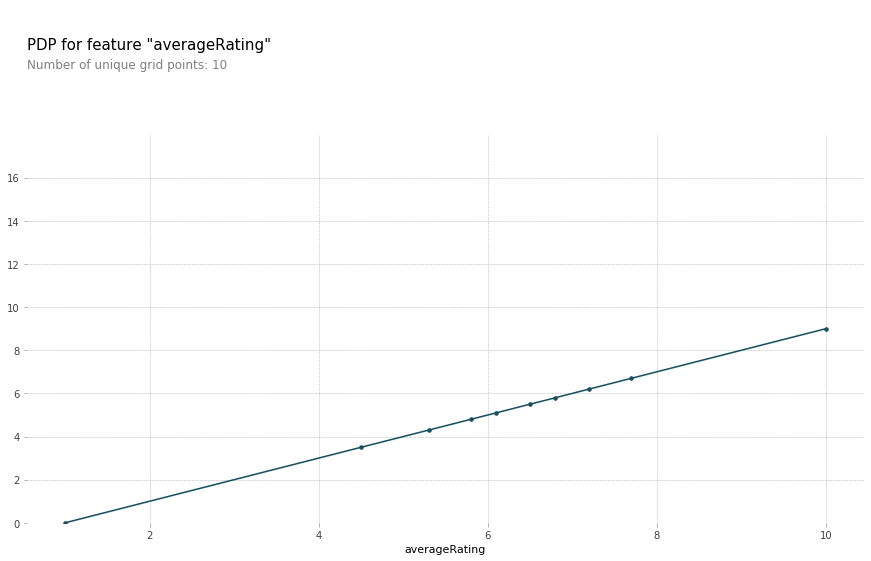

In [107]:
pdp_plot(isolated, feature_name=feature)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f794a4e0780>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f794ab7f4a8>})

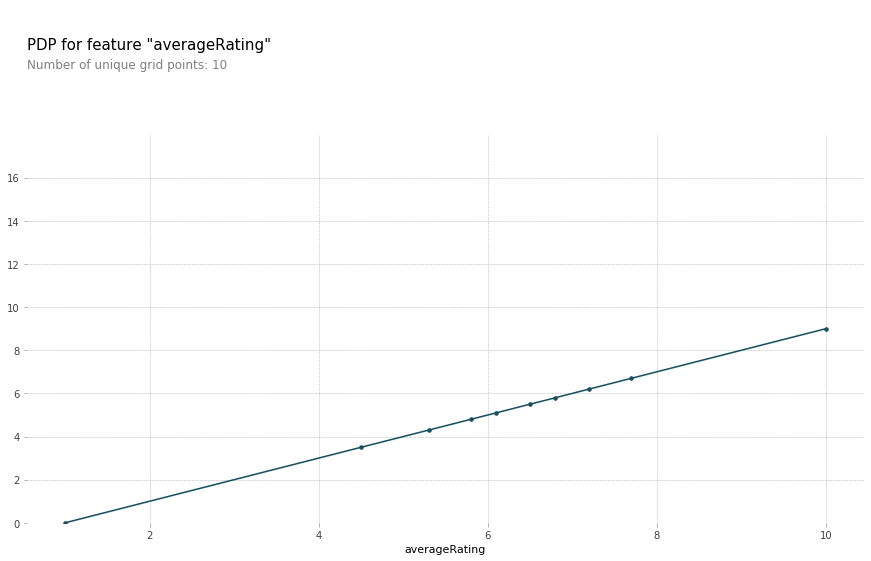

In [109]:
pdp_plot(isolated, feature_name=feature)
#plt.xlim((20000,150000));

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f7946a69b00>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f7947a2a128>})

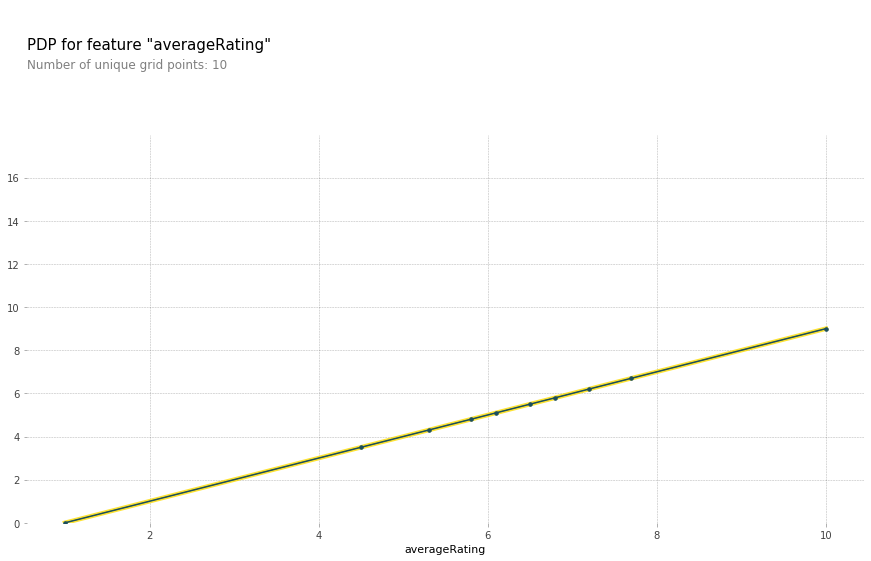

In [110]:
# Plot PDP with ICE curves
# PDP: Partial Dependence Plot
# ICE: Individual Conditional Expectation
pdp_plot(isolated, feature_name=feature, plot_lines=True, 
         frac_to_plot=0.01)

#plt.xlim(20000,150000);

Partial Dependence Plots with 2 features

In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [0]:
features = ['averageRating', 'numVotes']

interaction = pdp_interact(
    model=gb, 
    dataset=X_val,
    model_features=X_val.columns, 
    features=features
)

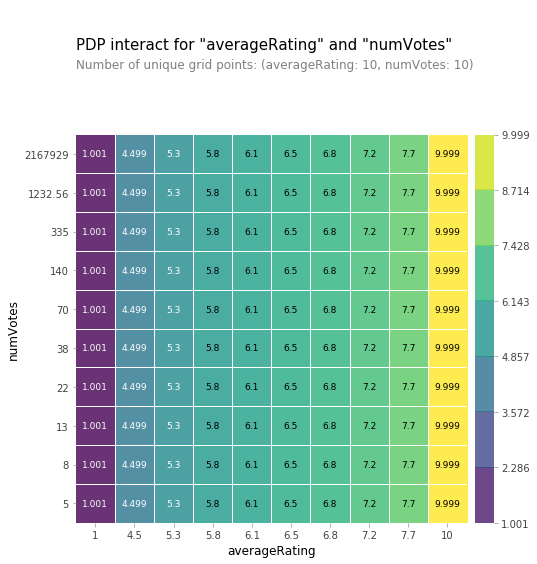

In [129]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

3D Partial dependence plot

In [0]:
# First, make the 2D plot above. Then ...

pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1]
)[::-1] # Slice notation to reverse index order so y axis is ascending

In [0]:
#pdp = pdp.drop(columns=[1.001, 9.999])

In [0]:
import plotly.graph_objs as go

surface = go.Surface(
    x=pdp.columns, 
    y=pdp.index, 
    z=pdp.values
)


layout = go.Layout(
    scene=dict(
        xaxis=dict(title=features[0]), 
        yaxis=dict(title=features[1]), 
        zaxis=dict(title=target)
    )
)

fig = go.Figure(surface, layout)
fig.show()